# BEE 4750 Homework 2: Dissolved Oxygen

**Name**: Anthony Nicolaides

**ID**: ajn68

> **Due Date**
>
> Friday, 09/22/23, 9:00pm

## Overview

### Instructions

This assignment asks you to use a simulation model for dissolved oxygen
to assess the impacts of two wastewater streams, including minimum
treatment levels and the impact of uncertain environmental conditions.
You will also be asked to identify a minimum distance for the addition
of a third discharge stream.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Documents/BEE4750/hw/hw02-anthonynic28`


In [2]:
using Plots
using LaTeXStrings
using Distributions

## Problems (Total: 40 Points)

A river which flows at 6 km/d is receiving waste discharges from two
sources which are 15 km apart, as shown in
<a href="#fig-river" class="quarto-xref">Figure 1</a>. The oxygen
reaeration rate is 0.55 day<sup>-1</sup>, and the decay rates of CBOD
and NBOD are are 0.35 and 0.25 day<sup>-1</sup>, respectively. The
river’s saturated dissolved oxygen concentration is 10 mg/L.

![Figure 1: Schematic of the
system](figures/river_diagram.png)

### Problem 1 (8 points)

If the characteristics of the river inflow and waste discharges are
given in <a href="#tbl-river" class="quarto-xref">Table 1</a>, write a
Julia model to compute the dissolved oxygen concentration from the first
wastewater discharge to an arbitrary distance `d` km downstream. Use
your model to compute the maximum dissolved oxygen concentration up to
50km downstream and how far downriver this maximum occurs.

|    Parameter     |            River Inflow |         Waste Stream 1 |         Waste Stream 2 |
|:----------------:|------------------------:|-----------------------:|-----------------------:|
|      Inflow      |             100,000 L/d |             10,000 L/d |             15,000 L/d |
| DO Concentration |                7.5 mg/L |                 5 mg/L |                 5 mg/L |
|       CBOD       |                  5 mg/L |                50 mg/L |                45 mg/L |
|       NBOD       |                  5 mg/L |                35 mg/L |                35 mg/L |

Table 1: River inflow and waste stream characteristics for Problem 1.

In [3]:
ka = 0.55 # day^(-1); oxygen reaeration rate
kc = 0.35 # day^(-1); decay rate of CBOD
kn = 0.25 # day^(-1); decay rate of NBOD

Cs = 10 # mg/L

U = 6 # km/d

d_streams = 15 # km

Q_river = 100000 # L/d
Q_stream1 = 10000 # L/d
Q_stream2 = 15000 # L/d

DO_river = 7.5 # mg/L
DO_stream1 = 5 # mg/L
DO_stream2 = 5 # mg/L

CBOD_river = 5 # mg/L
CBOD_stream1 = 50 # mg/L
CBOD_stream2 = 45 # mg/L

NBOD_river = 5 # mg/L
NBOD_stream1 = 35 # mg/L
NBOD_stream2 = 35 # mg/L

# calculating the initial condition of box 1
C0_box1 = ((DO_river * Q_river) + (DO_stream1 * Q_stream1)) /
          (Q_river + Q_stream1) # mg/L; initial DO concentration
B0_box1 = ((CBOD_river * Q_river) + (CBOD_stream1 * Q_stream1)) /
          (Q_river + Q_stream1) # mg/L; initial CBOD concentration
N0_box1 = ((NBOD_river * Q_river) + (NBOD_stream1 * Q_stream1)) /
          (Q_river + Q_stream1) # mg/L; initial NBOD concentration

# calculating the initial condition of box 2 (based on the outflow of box 1 
#    at x = 15 km)
x_box2 = d_streams
alpha_1 = exp((-ka * x_box2) / U)
alpha_2 = (kc / (ka - kc)) * (exp((-kc * x_box2) / U) - alpha_1)
alpha_3 = (kn / (ka - kn)) * (exp((-kn * x_box2) / U) - alpha_1)
DO_box2 = (Cs * (1 - alpha_1)) +
          (C0_box1 * alpha_1) -
          (B0_box1 * alpha_2) -
          (N0_box1 * alpha_3)
CBOD_box2 = B0_box1 * exp((-kc * d_streams) / U)
NBOD_box2 = N0_box1 * exp((-kn * d_streams) / U)

C0_box2 = ((DO_box2 * Q_river) + (DO_stream2 * Q_stream2)) /
          (Q_river + Q_stream2) # mg/L; initial DO concentration
B0_box2 = ((CBOD_box2 * Q_river) + (CBOD_stream2 * Q_stream2)) /
          (Q_river + Q_stream2) # mg/L; initial CBOD concentration
N0_box2 = ((NBOD_box2 * Q_river) + (NBOD_stream2 * Q_stream2)) /
          (Q_river + Q_stream2) # mg/L; initial NBOD concentration

function dissolved_oxygen(x, Cs,
     C0_box1, B0_box1, N0_box1,
     C0_box2, B0_box2, N0_box2,
     ka, kc, kn, U, d_streams)
     # Finds the DO concentration x km away from stream 1
     if x <= d_streams
          alpha_1 = exp((-ka * x) / U)
          alpha_2 = (kc / (ka - kc)) * (exp((-kc * x) / U) - alpha_1)
          alpha_3 = (kn / (ka - kn)) * (exp((-kn * x) / U) - alpha_1)
          C = (Cs * (1 - alpha_1)) +
              (C0_box1 * alpha_1) -
              (B0_box1 * alpha_2) -
              (N0_box1 * alpha_3)
     elseif x > d_streams
          x = x - d_streams # Waste Steam 2 is where x = 0 is for box 2
          alpha_1 = exp((-ka * x) / U)
          alpha_2 = (kc / (ka - kc)) * (exp((-kc * x) / U) - alpha_1)
          alpha_3 = (kn / (ka - kn)) * (exp((-kn * x) / U) - alpha_1)
          C = (Cs * (1 - alpha_1)) +
              (C0_box2 * alpha_1) -
              (B0_box2 * alpha_2) -
              (N0_box2 * alpha_3)
     end
     return C # mg/L
end

dissolved_oxygen (generic function with 1 method)

In [4]:
x_step = 0.01 # km
x_max = 50 # km
x = 0:x_step:x_max # array from 0 to x_max in stepsize x_step

C = (y -> dissolved_oxygen(y, Cs,
    C0_box1, B0_box1, N0_box1,
    C0_box2, B0_box2, N0_box2,
    ka, kc, kn, U, d_streams)).(x)

min_index = (findmin(C)[2] - 1) * x_step
max_index = (findmax(C)[2] - 1) * x_step
println("Looking up to 50 km downstream from waste stream 1: ")
println("   Minimum DO concentration is ", round(findmin(C)[1], digits=3),
    " mg/L, located ", min_index, " km from waste stream 1")
println("   Maximum DO concentration is ", round(findmax(C)[1], digits=3),
    " mg/L, located ", max_index, " km from waste stream 1")

Looking up to 50 km downstream from waste stream 1: 
   Minimum DO concentration is 3.587 mg/L, located 22.7 km from waste stream 1
   Maximum DO concentration is 7.273 mg/L, located 0.0 km from waste stream 1


### Problem 2 (4 points)

Use your model to plot the dissolved oxygen concentration in the river
from the first waste stream to 50km downstream. What do you notice?

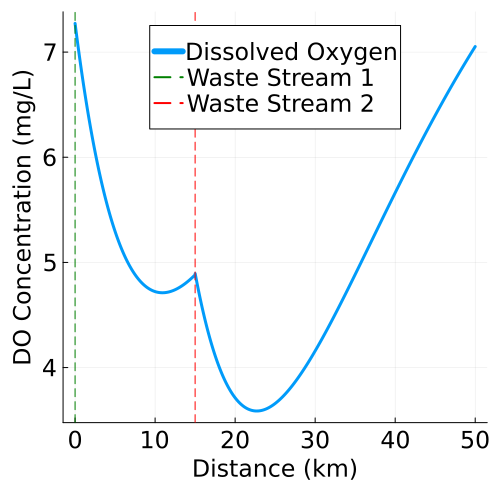

In [5]:
x_step = 0.01 # km
x_max = 50 # km
x = 0:x_step:x_max # array from 0 to x_max in stepsize x_step

C = (y -> dissolved_oxygen(y, Cs,
    C0_box1, B0_box1, N0_box1,
    C0_box2, B0_box2, N0_box2,
    ka, kc, kn, U, d_streams)).(x)


plot(x, C; linewidth=3,
    label="Dissolved Oxygen",
    tickfontsize=16,
    guidefontsize=16,
    legendfontsize=16,
    legend=:top)
xlabel!("Distance (km)")
ylabel!("DO Concentration (mg/L)")
vline!([0], color=:green,
    linestyle=:dash,
    label="Waste Stream 1")
vline!([d_streams], color=:red,
    linestyle=:dash,
    label="Waste Stream 2")
plot!(size=(500, 500))

I notice that immediately after the waste stream occurs, the DO concentration begins to steadily decline until reaching a minimum. Afterwards, the DO concentraion is able to slightly recover until it reached the second waste stream where the DO concentration tanks even more due to CBOD and NBOD input. Afterwards reaching a minimum, it steadily begins to increase as the river flows further way from the waste streams.

### Problem 3 (3 points)

Under the assumptions of Problem 1, determine the distance from waste
stream 2 it will take for the dissolved oxygen concentration of the
river to recover to 6 mg/L.

In [6]:
x0 = d_streams # km; x = 15 for the function to start at waste stream 2
x_step = 0.01 # km
dist_from_stream2 = dissolved_oxygen(x0, Cs,
    C0_box1, B0_box1, N0_box1,
    C0_box2, B0_box2, N0_box2,
    ka, kc, kn, U, d_streams) # km
while dist_from_stream2 < 6
    x0 = x0 + x_step
    dist_from_stream2 = dissolved_oxygen(x0, Cs,
        C0_box1, B0_box1, N0_box1,
        C0_box2, B0_box2, N0_box2,
        ka, kc, kn, U, d_streams)
end
# find distance with waste stream 2 being at x = 0
DO_recovery_dist = round(x0 - d_streams, digits=2)
println("The DO concentration will recover to 6 mg/L at ",
    DO_recovery_dist, " km away from waste stream 2")

The DO concentration will recover to 6 mg/L at 27.24 km away from waste stream 2


### Problem 4 (5 points)

What is the minimum level of treatment (% removal of organic waste) for
waste stream 2 that will ensure that the dissolved oxygen concentration
never drops below 4 mg/L, assuming that waste stream 1 remains
untreated?

In [7]:
function dCdx_function(x, Cs,
    C0_box1, B0_box1, N0_box1,
    C0_box2, B0_box2, N0_box2,
    ka, kc, kn, U, d_streams)
    # derivative of the dissolved oxygen equation, this is used to find 
    #   where the local minimum of DO concentration starting at x km from 
    #   waste stream 1
    if x < d_streams # waste stream 1
        dC_alpha1 = (-ka / U) * exp((-ka * x) / U)
        dC_alpha2 = (kc / (ka - kc)) *
                    (((-kc / U) * exp((-kc * x) / U)) - dC_alpha1)
        dC_alpha3 = (kn / (ka - kn)) *
                    (((-kn / U) * exp((-kn * x) / U)) - dC_alpha1)
        dC = (-Cs * dC_alpha1) +
             (C0_box1 * dC_alpha1) -
             (B0_box1 * dC_alpha2) -
             (N0_box1 * dC_alpha3)
    elseif x >= d_streams # waste stream 2
        x = x - d_streams
        dC_alpha1 = (-ka / U) * exp((-ka * x) / U)
        dC_alpha2 = (kc / (ka - kc)) *
                    (((-kc / U) * exp((-kc * x) / U)) - dC_alpha1)
        dC_alpha3 = (kn / (ka - kn)) *
                    (((-kn / U) * exp((-kn * x) / U)) - dC_alpha1)
        dC = (-Cs * dC_alpha1) +
             (C0_box2 * dC_alpha1) -
             (B0_box2 * dC_alpha2) -
             (N0_box2 * dC_alpha3)
    end
    return dC
end

function find_min_DO(x, Cs,
    C0_box1, B0_box1, N0_box1,
    C0_box2, B0_box2, N0_box2,
    ka, kc, kn, U, d_streams)
    # function that uses dCdx_function() to find where the local minimum DO 
    #   concentration is and what the value is

    # intialize values
    x_step = 0.01 # km
    slope = dCdx_function(x, Cs,
        C0_box1, B0_box1, N0_box1,
        C0_box2, B0_box2, N0_box2,
        ka, kc, kn, U, d_streams)

    # DO concentration starts off decreasing --> slope is negative; When
    #   slope stops being negative that means it is very close to a zero, 
    #   which represents a local minimum
    while slope < 0
        x = x + x_step
        slope = dCdx_function(x, Cs,
            C0_box1, B0_box1, N0_box1,
            C0_box2, B0_box2, N0_box2,
            ka, kc, kn, U, d_streams)
    end
    # x is now where the lowest DO concentrration is located

    # find what the DO concentration is at that minimum x value
    min_DO = dissolved_oxygen(x, Cs,
        C0_box1, B0_box1, N0_box1,
        C0_box2, B0_box2, N0_box2,
        ka, kc, kn, U, d_streams)
    return min_DO, x
end

find_min_DO (generic function with 1 method)

In [8]:
treatment_level = 0
x = d_streams # km
min_DO = 0 # mg/L
regulation_standard = 4 # mg/L
while treatment_level <= 1

    # find new initial conditions for treated stream 2
    B0_box2_treated = ((CBOD_box2 * Q_river) +
                       (CBOD_stream2 * (1 - treatment_level) *
                        Q_stream2)) / (Q_river + Q_stream2) # mg/L
    N0_box2_treated = ((NBOD_box2 * Q_river) +
                       (NBOD_stream2 * (1 - treatment_level) *
                        Q_stream2)) / (Q_river + Q_stream2) # mg/L

    # find what the DO concentration is at that minimum x value
    min_DO = find_min_DO(x, Cs,
        C0_box1, B0_box1, N0_box1,
        C0_box2, B0_box2_treated, N0_box2_treated,
        ka, kc, kn, U, d_streams)[1]

    # check if streams lowest DO concentration are within 
    #   regulation standard
    if min_DO >= regulation_standard
        break
    end

    # if treatment is not enough --> increase treatment
    treatment_level = treatment_level + 0.01
end


# formatting
min_DO = round(min_DO, digits=3)
percentage_treatment_level_stream1 = round(100 * treatment_level, digits=2)
println("Minimum treatment level for stream 2 = ",
    percentage_treatment_level_stream1, "% 
    Resulting minimum DO concentration = ", min_DO, " mg/L")

Minimum treatment level for stream 2 = 18.0% 
    Resulting minimum DO concentration = 4.001 mg/L


### Problem 5 (5 points)

If both waste streams are treated equally, what is the minimum level of
treatment (% removal of organic waste) for the two sources required to
ensure that the dissolved oxygen concentration never drops below 4 mg/L?

In [9]:
function Problem5(C0_box1)
    treatment_level = 0
    x_from_stream1 = 0 # km
    x_from_stream2 = d_streams # km
    regulation_standard = 4 # mg/L
    min_DO_box1 = 0 # mg/L
    min_DO_box2 = 0 # mg/L
    while treatment_level <= 1

        # find new initial conditions for treated stream 1
        B0_box1_treated = ((CBOD_river * Q_river) +
                           (CBOD_stream1 * (1 - treatment_level) *
                            Q_stream1)) / (Q_river + Q_stream1) # mg/L
        N0_box1_treated = ((NBOD_river * Q_river) +
                           (NBOD_stream1 * (1 - treatment_level) *
                            Q_stream1)) / (Q_river + Q_stream1) # mg/L

        min_DO_box1 = find_min_DO(x_from_stream1, Cs,
            C0_box1, B0_box1_treated, N0_box1_treated,
            C0_box2, B0_box2, N0_box2, ka, kc, kn, U, d_streams)[1]

        # recalculate values needed for initial conditions of stream 2
        x_box2 = d_streams
        alpha_1_altered = exp((-ka * x_box2) / U)
        alpha_2_altered = (kc / (ka - kc)) *
                          (exp((-kc * x_box2) / U) - alpha_1_altered)
        alpha_3_altered = (kn / (ka - kn)) *
                          (exp((-kn * x_box2) / U) - alpha_1_altered)
        DO_box2_altered = (Cs * (1 - alpha_1_altered)) +
                          (C0_box1 * alpha_1_altered) -
                          (B0_box1_treated * alpha_2_altered) -
                          (N0_box1_treated * alpha_3_altered)
        CBOD_box2_altered = B0_box1_treated * exp((-kc * x_box2) / U)
        NBOD_box2_altered = N0_box1_treated * exp((-kn * x_box2) / U)

        # find new initial conditions for treated stream 2
        C0_box2_altered = ((DO_box2_altered * Q_river) +
                           (DO_stream2 * Q_stream2)) /
                          (Q_river + Q_stream2) # mg/L
        B0_box2_treated = ((CBOD_box2_altered * Q_river) +
                           (CBOD_stream2 * (1 - treatment_level) *
                            Q_stream2)) / (Q_river + Q_stream2) # mg/L
        N0_box2_treated = ((NBOD_box2_altered * Q_river) +
                           (NBOD_stream2 * (1 - treatment_level) *
                            Q_stream2)) / (Q_river + Q_stream2) # mg/L

        min_DO_box2 = find_min_DO(x_from_stream2, Cs,
            C0_box1, B0_box1_treated, N0_box1_treated,
            C0_box2_altered, B0_box2_treated, N0_box2_treated,
            ka, kc, kn, U, d_streams)[1]

        # check if both streams' lowest DO concentration are within 
        #   regulation standard
        if (min_DO_box1 >= regulation_standard) &&
           (min_DO_box2 >= regulation_standard)
            break
        end

        # if treatment is not enough --> increase treatment
        treatment_level = treatment_level + 0.01
    end

    # formatting

    return treatment_level, min_DO_box1, min_DO_box2
end

# Call function and format output
treatment_level, min_DO_box1, min_DO_box2 = Problem5(C0_box1)
min_DO_box1 = round(min_DO_box1, digits=3)
min_DO_box2 = round(min_DO_box2, digits=3)
percentage_treatment_level_both_streams = round(100 * treatment_level,
    digits=2)
println("   Minimum treatment level for streams = ",
    percentage_treatment_level_both_streams, "% 
            Resulting minimum DO concentration for stream 1 = ",
    min_DO_box1, " mg/L
            Resulting minimum DO concentration for stream 2 = ",
    min_DO_box2, " mg/L")

   Minimum treatment level for streams = 11.0% 
            Resulting minimum DO concentration for stream 1 = 4.93 mg/L
            Resulting minimum DO concentration for stream 2 = 4.019 mg/L


### Problem 6 (5 points)

Suppose you are responsible for designing a waste treatment plan for
discharges into the river, with a regulatory mandate to keep the
dissolved oxygen concentration above 4 mg/L. Discuss whether you’d opt
to treat waste stream 2 alone or both waste streams equally. What other
information might you need to make a conclusion, if any?

Problem 4 Treatment Plan: 18% treatment for waster stream 2

Problem 5 Treatment Plan: 11% treatment for waster stream 1 & 2

Given the current information, I believe Problem 4 Treatment Plan would be the best option because the amount of treatment waste stream 2 has to do in Problem 4 vs Problem 5 is only 7%. However, more information would be needed to decsively conclude this. An important factor to keep in is the cost of treatment for each waste stream. It could be that waste stream 2's treatment is very expensive to the point where that 7% difference is very drastic in cost. Moreover, perhaps waste stream 1's treatment is very cheap so giving them a treatment plan and trying to minimze waste stream 2's treatment plan might be better. In addition to cost, factors like energy consumption would also need to be considered for similar reasons to cost.

### Problem 7 (5 points)

Suppose that it is known that the DO concentrations at the river inflow
can vary uniformly between 6 mg/L and 8 mg/L. How often will the
treatment plan identified in Problem 5 (both waste streams treated
equally) fail to comply with the regulatory standard?

In [10]:
min_DO_river = 6 # mg/L
max_DO_river = 8 # mg/L
step_DO_river = 0.001 # mg/L
treatment_level_from_Problem5 = Problem5(C0_box1)[1]

# uniformly distributed DO concentration
DO_river_dist = Uniform(min_DO_river, max_DO_river)

sample_size = 100000 # large sample size to have value converge
fail_to_comply = 0

# Monte Carlo simulation
for n = 1:sample_size
    DO_river_sample = rand(DO_river_dist) # simulate DO concentration
    C0_box1_altered = ((DO_river_sample * Q_river) +
                       (DO_stream1 * Q_stream1)) /
                      (Q_river + Q_stream1) # mg/L
    treatment_level_altered_DO = Problem5(C0_box1_altered)[1]
    if treatment_level_altered_DO > treatment_level_from_Problem5
        fail_to_comply = fail_to_comply + 1
    end
end
# formatting
fail_to_comply_percentage = round((fail_to_comply / sample_size) * 100,
    digits=2)
println("If the DO concentration at the river infow varies from ",
    min_DO_river, " mg/L to ", max_DO_river, " mg/L, 
    then the Problem 5 treatment plan, will fail ",
    fail_to_comply_percentage, "% of the time")

If the DO concentration at the river infow varies from 6 mg/L to 8 mg/L, 
    then the Problem 5 treatment plan, will fail 65.61% of the time


### Problem 8 (5 points)

A factory is planning a third wastewater discharge into the river
downstream of the second plant. This discharge would consist of 5000
L</sup>/day of wastewater with a dissolved oxygen content of 4.5
mg/L and CBOD and NBOD levels of 50 and 45 mg/L, respectively.

Assume that the treatment plan you identified in Problem 5 is still in
place for the existing discharges. If the third discharge will not be
treated, under the original inflow conditions (7.5 mg/L DO), how far
downstream from the second discharge does this third discharge need to
be placed to keep the river concentration from dropping below 4 mg/L?

In [11]:
function dissolved_oxygen_stream3(x, Cs,
    C0_box3, B0_box3, N0_box3,
    ka, kc, kn, U, D)
    # Finds DO concentration x km away from stream 3
    # Stream 3 has its own function for simplicity
    x = x - D # set x = 0 to be at waste stream 3
    alpha_1 = exp((-ka * x) / U)
    alpha_2 = (kc / (ka - kc)) * (exp((-kc * x) / U) - alpha_1)
    alpha_3 = (kn / (ka - kn)) * (exp((-kn * x) / U) - alpha_1)
    C = (Cs * (1 - alpha_1)) +
        (C0_box3 * alpha_1) -
        (B0_box3 * alpha_2) -
        (N0_box3 * alpha_3)
    return C
end

function dCdx_function_stream3(x, Cs,
    C0_box3, B0_box3, N0_box3,
    ka, kc, kn, U, D)
    # derivative of the dissolved oxygen equation, this is used to find 
    #   where the local minimum of DO concentration starting at x km from 
    #   waste stream 1
    # Stream 3 has its own function for simplicity
    x = x - D # set x = 0 to be at waste stream 3
    dC_alpha1 = (-ka / U) * exp((-ka * x) / U)
    dC_alpha2 = (kc / (ka - kc)) *
                (((-kc / U) * exp((-kc * x) / U)) - dC_alpha1)
    dC_alpha3 = (kn / (ka - kn)) *
                (((-kn / U) * exp((-kn * x) / U)) - dC_alpha1)
    dC = (-Cs * dC_alpha1) +
         (C0_box3 * dC_alpha1) -
         (B0_box3 * dC_alpha2) -
         (N0_box3 * dC_alpha3)
    return dC
end

function find_min_DO_stream3(D, Cs,
    C0_box3, B0_box3, N0_box3,
    ka, kc, kn, U)
    # function that uses dCdx_function() to find where the local minimum DO 
    #   concentration is and what the value is
    # Stream 3 has its own function for simplicity
    
    D_x = D # km
    D_x_step = 0.01 # km
    # find minimum x of curve via searching for a zero in the derivative
    slope_box3 = dCdx_function_stream3(D_x, Cs,
        C0_box3, B0_box3, N0_box3,
        ka, kc, kn, U, D)

    # DO concentration starts off decreasing --> slope is negative; When
    #   slope stops being negative that means it is very close to a zero, 
    #   which represents a local minimum
    while slope_box3 < 0
        D_x = D_x + D_x_step
        slope_box3 = dCdx_function_stream3(D_x, Cs,
            C0_box3, B0_box3, N0_box3,
            ka, kc, kn, U, D)
    end
    # D_x is now where the lowest DO concentrration is located

    # find what the DO concentration is at that minimum x value
    min_DO_box3 = dissolved_oxygen_stream3(D_x, Cs,
        C0_box3, B0_box3, N0_box3,
        ka, kc, kn, U, D)

    return min_DO_box3, D_x
end

find_min_DO_stream3 (generic function with 1 method)

In [12]:
Q_stream3 = 5000 # L/d
DO_stream3 = 4.5 # mg/L
CBOD_stream3 = 50 # mg/L
NBOD_stream3 = 45 # mg/L

# Get treatment plan from Problem 5 and recalculate needed values
treatment_level_from_Problem5 = Problem5(C0_box1)[1]
B0_box1_treated = ((CBOD_river * Q_river) +
                   (CBOD_stream1 * (1 - treatment_level_from_Problem5) *
                    Q_stream1)) / (Q_river + Q_stream1) # mg/L
N0_box1_treated = ((NBOD_river * Q_river) +
                   (NBOD_stream1 * (1 - treatment_level_from_Problem5) *
                    Q_stream1)) / (Q_river + Q_stream1) # mg/L

# recalculate values needed for initial conditions of stream 2
x_box2 = d_streams
alpha_1_altered = exp((-ka * x_box2) / U)
alpha_2_altered = (kc / (ka - kc)) *
                  (exp((-kc * x_box2) / U) - alpha_1_altered)
alpha_3_altered = (kn / (ka - kn)) *
                  (exp((-kn * x_box2) / U) - alpha_1_altered)
DO_box2_altered = (Cs * (1 - alpha_1_altered)) +
                  (C0_box1 * alpha_1_altered) -
                  (B0_box1_treated * alpha_2_altered) -
                  (N0_box1_treated * alpha_3_altered)
CBOD_box2_altered = B0_box1_treated * exp((-kc * x_box2) / U)
NBOD_box2_altered = N0_box1_treated * exp((-kn * x_box2) / U)

# find new initial conditions for treated stream 2
C0_box2_altered = ((DO_box2_altered * Q_river) +
                   (DO_stream2 * Q_stream2)) / (Q_river + Q_stream2) # mg/L
B0_box2_treated = ((CBOD_box2_altered * Q_river) +
                   (CBOD_stream2 * (1 - treatment_level) *
                    Q_stream2)) / (Q_river + Q_stream2) # mg/L
N0_box2_treated = ((NBOD_box2_altered * Q_river) +
                   (NBOD_stream2 * (1 - treatment_level) *
                    Q_stream2)) / (Q_river + Q_stream2) # mg/L

D = 0 # km
D_step = 0.1 # km

min_DO_box3 = 0 # mg/L
regulation_standard = 4 # mg/L
while min_DO_box3 < regulation_standard
    # calculating the initial condition of box 3 (based on the outflow of 
    #   box 2 at x = D km)
    x_box3 = D
    alpha_1_altered = exp((-ka * x_box3) / U)
    alpha_2_altered = (kc / (ka - kc)) *
                      (exp((-kc * x_box3) / U) - alpha_1_altered)
    alpha_3_altered = (kn / (ka - kn)) *
                      (exp((-kn * x_box3) / U) - alpha_1_altered)
    DO_box3 = (Cs * (1 - alpha_1_altered)) +
              (C0_box2_altered * alpha_1_altered) -
              (B0_box2_treated * alpha_2_altered) -
              (N0_box2_treated * alpha_3_altered)
    CBOD_box3 = B0_box2_treated * exp((-kc * x_box3) / U)
    NBOD_box3 = N0_box2_treated * exp((-kn * x_box3) / U)

    # new initial conditions for stream 3 that is D km away from stream 2
    C0_box3 = ((DO_box3 * Q_river) + (DO_stream3 * Q_stream3)) /
              (Q_river + Q_stream3) # mg/L
    B0_box3 = ((CBOD_box3 * Q_river) + (CBOD_stream3 * Q_stream3)) /
              (Q_river + Q_stream3) # mg/L
    N0_box3 = ((NBOD_box3 * Q_river) + (NBOD_stream3 * Q_stream3)) /
              (Q_river + Q_stream3) # mg/L

    # find minimum DO concentration from waste stream 3 is it D km from 
    #   waste stream 2
    min_DO_box3 = find_min_DO_stream3(D, Cs,
        C0_box3, B0_box3, N0_box3,
        ka, kc, kn, U)[1]

    # if D km away from stream 2 is not enough --> increase D
    D = D + D_step
end
D = D - D_step # undo last D = D + D_step

# formatting
min_DO_box3 = round(min_DO_box3, digits=4)
min_distance_from_stream2 = round(D, digits=3)
println("Under the Problem 5 treatment plan,
    Minimum distance stream 3 can be placed from stream 2 = ",
    min_distance_from_stream2, " km
    Resulting minimum DO concentration for stream 3 = ",
    min_DO_box3, " mg/L")


Under the Problem 5 treatment plan,
    Minimum distance stream 3 can be placed from stream 2 = 11.1 km
    Resulting minimum DO concentration for stream 3 = 4.0001 mg/L


## References

List any external references consulted, including classmates.

BEE 4750 9/08 Lecture "Dissolved Oxygen" Slides

BEE 4750 9/11 Lecture "Dissolved Oxygen Simulation" Slides & equations

BEE 4750 9/11 Lecture "Dissolved Oxygen Simulation" Slides, equations, & code from "Julia Sidebar sections"